In [ ]:
#!jupyter nbconvert --to script perform_linear_test.ipynb

In [1]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd
import scipy.stats as stats
from random import shuffle
from multiprocessing import Pool,Array
import sys
import json
import seaborn as sns
from matplotlib import pyplot as plt
njobs=40
from joblib import Memory, Parallel, delayed
mem = Memory('/tmp/joblib/')



In [2]:
def bin_variable(var1):   # bin with normalization
    
    var1=np.array(var1).astype(np.float)
    
    if abs(np.std(var1))>0.01:
        var1 = (var1 - np.mean(var1))/np.std(var1)
    else:
        var1 = (var1 - np.mean(var1))
    val1 = np.digitize(var1, np.histogram(var1, bins='fd')[1])
    #print(type(val1))
    #print((val1).shape())
    return val1

def p_val_mi(x,y):
    count=0.0
    iterations=10000
    score=metrics.adjusted_mutual_info_score(x,y)
    for i in range(iterations):
        shuffle(x)
        shuffle(y)
        if metrics.adjusted_mutual_info_score(x,y)>=score:
            count+=1.0
    return count/iterations
        
pearsonc=lambda x,y : stats.pearsonr(np.array(x),np.array(y))[0]
p_val_test1=lambda x,y :stats.pearsonr(np.array(x),np.array(y))[1]

ajd_mi_bin=lambda x,y : metrics.adjusted_mutual_info_score(bin_variable(x),bin_variable(y))
p_val_test2= lambda x,y : p_val_mi(bin_variable(x),bin_variable(y))

In [3]:
## Evaluating p-distribution for p-value computation
num_samples_estimation=100000
sig_to_noise_rate=[j*0.1 for j in range(21)] #0, 0.1 ,...,0.9, 1,...2
sig_to_noise_rate[0]=0.0001
num_points=[k*10 for k in range(1,16)]#10,20,30,...150

In [ ]:


def estimate_null_d_pearson(k):
    x = np.random.normal(0,1,k)
    y = np.random.normal(0,1,k)
    return pearsonc(x,y)
    
def estimate_null_d_MI(k):
    x = np.random.normal(0,1,k)
    y = np.random.normal(0,1,k)
    return ajd_mi_bin(x,y)

#chc_nd_pear = mem.cache(estimate_null_d_pearson)
#chc_nd_MI = mem.cache(estimate_null_d_MI)

values_pear=[]
values_MI=[]
# Pearson & MI
for idx_k,k in zip(range(len(num_points)),num_points):
    print('Number of points : '+str(k))
    v_mi=Parallel(n_jobs=njobs,backend="multiprocessing",verbose=1)(delayed(estimate_null_d_MI)(k) for i in range(num_samples_estimation))
    values_MI.append(v_mi)
    v_pear=Parallel(n_jobs=njobs,backend="multiprocessing",verbose=1)(delayed(estimate_null_d_pearson)(k) for i in range(num_samples_estimation))
    values_pear.append(v_pear)
    '''values_pear.append([])
    values_MI.append([])
        for i in range(num_samples_estimation):
        #print(i),
        x = np.random.normal(0,1,k)
        y = np.random.normal(0,1,k)
        values_pear[idx_k].append(pearsonc(x,y))
        values_MI[idx_k].append(ajd_mi_bin(x,y))'''
        
    with open('Pearson_samples_'+str(k)+'temp_H0.txt','wb') as outfile:
        json.dump(values_pear[idx_k],outfile)
        
    with open('Adj_MI_bin_samples_'+str(k)+'temp_H0.txt','wb') as outfile:
        json.dump(values_MI[idx_k],outfile)

In [ ]:
#Save data generated
#for i in range(len(values_pear)):
#    values_pear[i]=list(np.sort(values_pear[i],kind='mergesort'))
#    values_MI[i]=list(np.sort(values_MI[i],kind='mergesort'))
with open('Pearson_samples_H2.txt','wb') as outfile:
    json.dump(values_pear,outfile)
        
with open('Adj_MI_bin_samples_H2.txt','wb') as outfile:
    json.dump(values_MI,outfile)

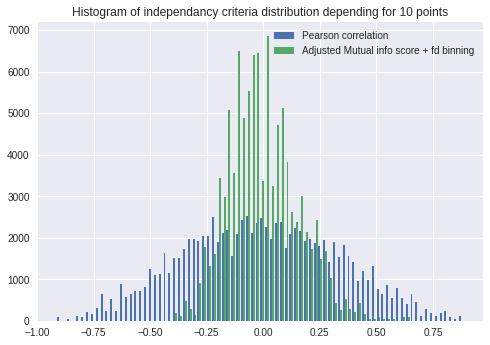

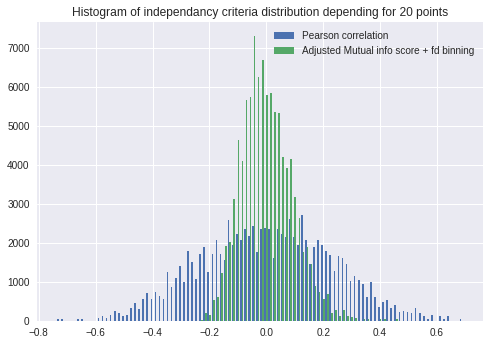

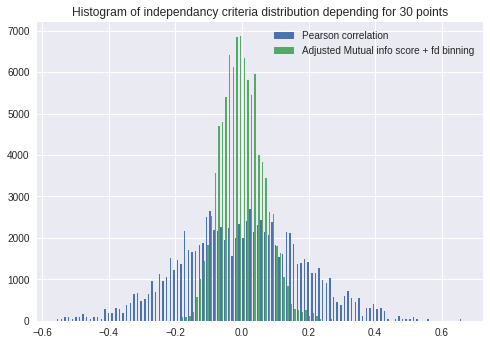

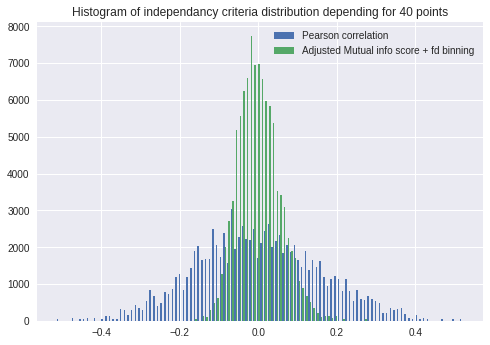

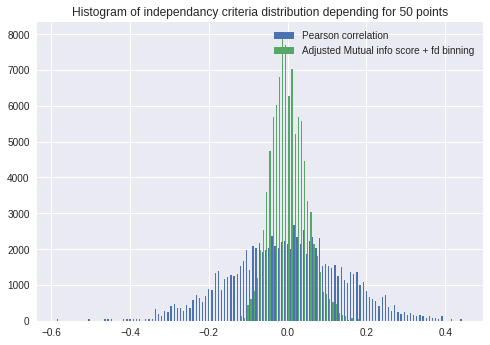

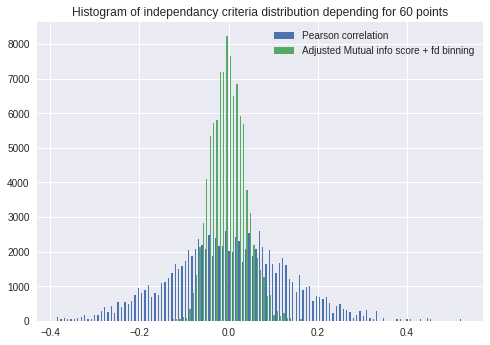

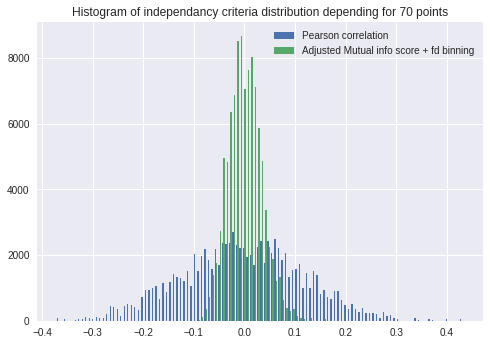

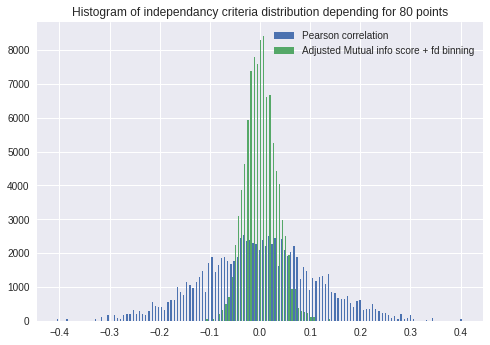

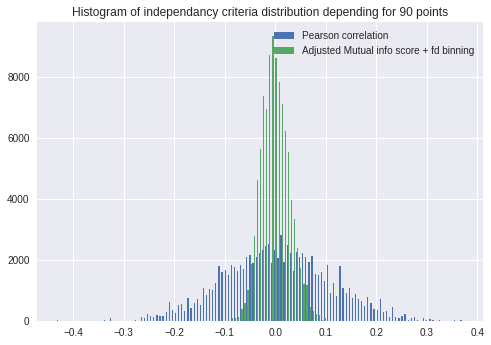

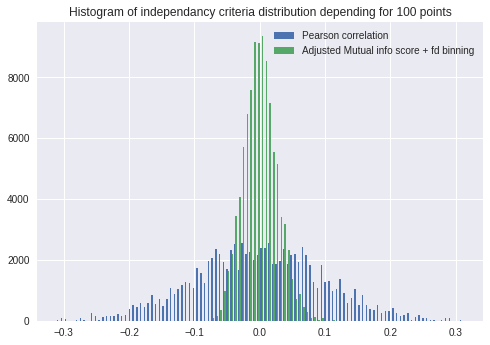

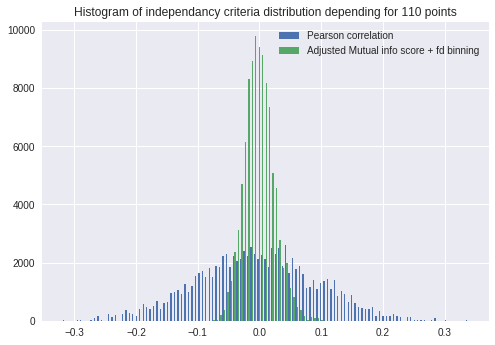

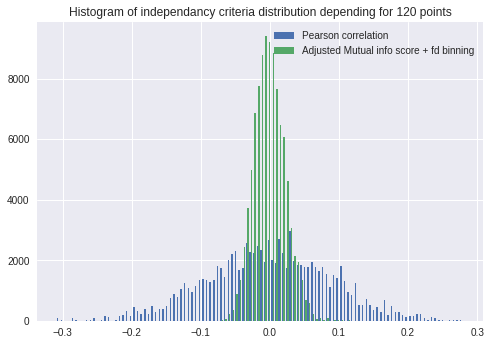

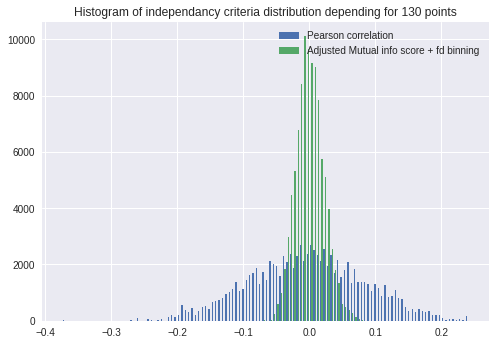

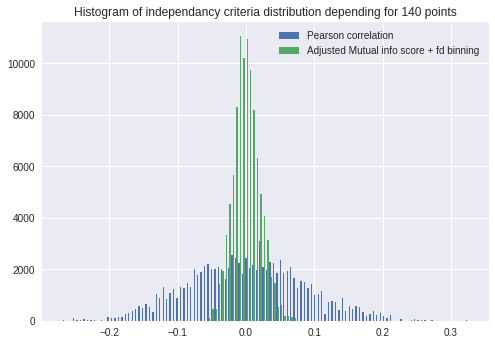

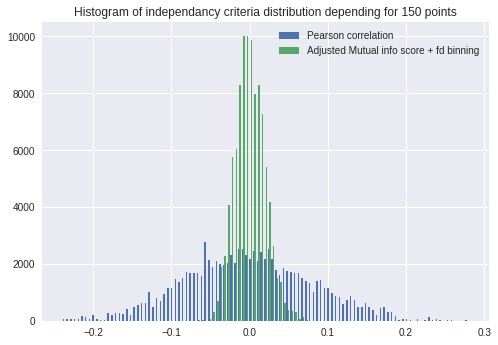

In [5]:
# Analyse density curves?
try:
    values_pear
except NameError:
    with open('Pearson_samples_H2.txt','rb') as input1:
        values_pear=json.load(input1)
    with open('Adj_MI_bin_samples_H2.txt','rb') as input2:
        values_MI=json.load(input2)
for i,nb_pts in zip(range(len(num_points)),num_points): 
    data = np.vstack([values_pear[i],values_MI[i]]).T
    plt.hist(data,bins='fd',label=['Pearson correlation','Adjusted Mutual info score + fd binning'])
    plt.title('Histogram of independancy criteria distribution depending for '+str(nb_pts) +' points')
    plt.legend(loc='upper right')
    plt.savefig('figures/histo_distrib2_'+str(nb_pts)+'_pts.png')
    plt.show()
    plt.clf()

In [ ]:
# Computation of pear & MI on linear data
def estimate_l_pearson(k,j):
    noise=np.random.normal(0,j,k)
    x=np.random.normal(0,1,k)
    y=[sum(s) for s in zip(x, noise)]
    return pearsonc(x,y)
    
def estimate_l_MI(k,j):
    noise=np.random.normal(0,j,k)
    x=np.random.normal(0,1,k)
    y=[sum(s) for s in zip(x, noise)]
    return ajd_mi_bin(x,y)

#chc_l_pear = mem.cache(estimate_l_pearson)
#chc_l_MI = mem.cache(estimate_l_MI)

num_samples_experiment=10000
result_pear=[]
pval_pear=[]
result_MI=[]
pval_MI=[]

for idx_j,j in zip(range(len(sig_to_noise_rate)),sig_to_noise_rate):
    result_pear.append([])
    print('-Sig/Noise : '+str(j))
    #result_anapear.append([])
    result_MI.append([]) 
    pval_pear.append([])
    pval_MI.append([])
    
    for idx_k,k in zip(range(len(num_points)),num_points):
        #print('--Number of points : '+str(k))        
        tmp_MI=Parallel(n_jobs=njobs,backend="multiprocessing",verbose=1)(
            delayed(estimate_l_MI)(k,j) for i in range(num_samples_experiment))
        result_MI[idx_j].append(tmp_MI)
        print(tmp_MI)
        tmp_pear=Parallel(n_jobs=njobs,backend="multiprocessing",verbose=1)(
            delayed(estimate_l_pearson)(k,j) for i in range(num_samples_experiment))
        result_pear[idx_j].append(tmp_pear)
        '''for i in range(num_samples_experiment):
            #generate the mecanism
            #print(j),
            #print(k)
            noise=np.random.normal(0,j,k)
            x=np.random.normal(0,1,k)
            y=[sum(s) for s in zip(x, noise)]
            #print(x)
            #print(y)
            pear=pearsonc(x,y)
            MI_score=ajd_mi_bin(x,y)
            result_pear[idx_j][idx_k].append(pear)
            result_MI[idx_j][idx_k].append(MI_score)'''
            
            
'''p_rank_MI=0.0
            p_rank_pear=0.0
            
            for pval in range(len(values_pear[idx_k])):
                if values_pear[idx_k][pval]>pear:
                    p_rank_pear+=1.0
            
            for pval in range(len(values_pear[idx_k])):
                if values_MI[idx_k][pval]>MI_score:
                    p_rank_MI+=1.0
            
            #while values_pear[idx_k][int(p_rank_pear)]>pear and p_rank_pear>0:
            #    p_rank_pear-=1.0
            #while values_MI[idx_k][int(p_rank_MI)]>pear and p_rank_MI>0:
            #    p_rank_MI-=1.0
            
            #pval_pear[idx_j][idx_k].append((len(values_pear[idx_k])-p_rank_pear)
                                           #/len(values_pear[idx_k]))
            #pval_MI[idx_j][idx_k].append((len(values_MI[idx_k])-p_rank_MI)
                                           #/len(values_MI[idx_k]))
            pval_pear[idx_j][idx_k].append(p_rank_pear/len(values_pear[idx_k]))
            # print(p_rank_pear/len(values_pear[idx_k])),
            pval_MI[idx_j][idx_k].append(p_rank_MI/len(values_MI[idx_k]))
            # print(p_rank_MI/len(values_MI[idx_k]))'''

In [ ]:
#Save final results
'''with open('Pearson_p_values2.txt','wb') as outfile:
    json.dump(pval_pear,outfile)
        
with open('Adj_MI_p_values2.txt','wb') as outfile:
    json.dump(pval_MI,outfile)'''

with open('Pearson_coeff3.txt','wb') as outfile:
    json.dump(result_pear,outfile)
        
with open('Adj_MI_coeff3.txt','wb') as outfile:
    json.dump(result_MI,outfile)

In [ ]:
def compute_FDR_MI(idx_j,idx_k,MI_score):
    #Rank on Null distribution
    p_rank_MI   = 0.0
    #Rank on alternative distribution
    a_rank_MI   = 0.0

    for pval in range(len(values_MI[idx_k])):
        if values_MI[idx_k][pval]>MI_score:
            p_rank_MI+=1.0 

    for aval in range(len(result_MI[idx_j][idx_k])):
        if result_MI[idx_j][idx_k][aval]>MI_score:
            a_rank_MI+=1.0

    try: 
        return p_rank_MI/(p_rank_MI+a_rank_MI)
    except ZeroDivisionError:
        return 0
    
def compute_FDR_pear(idx_j,idx_k,pear):
    p_rank_pear = 0.0 #Rank on Null distribution
    a_rank_pear = 0.0 #Rank on alternative distribution

    for pval in range(len(values_pear[idx_k])):
        if values_pear[idx_k][pval]>pear:
            p_rank_pear+=1.0

    for aval in range(len(result_pear[idx_j][idx_k])):
        if result_pear[idx_j][idx_k][aval]>pear:
            a_rank_pear+=1.0
    try:
        return p_rank_pear/(p_rank_pear+a_rank_pear)
    except ZeroDivisionError:
        return 0
    #print(p_rank_MI/(p_rank_MI+a_rank_MI)),
    #print(pval_MI[idx_j][idx_k][idx_l]*num_samples_estimation/(p_rank_MI+a_rank_MI))
#cached_fdr_mi = mem.cache(compute_FDR_MI)
#cached_fdr_pear = mem.cache(compute_FDR_pear)


In [ ]:
#Compute FDR : 
try: 
    result_pear
except NameError:
    with open('Adj_MI_coeff2.txt','r') as outfile:
        result_pear=json.load(outfile)
        
    with open('Adj_MI_coeff2.txt','r') as outfile:
        result_MI=json.load(outfile)

FDR_MI=[]
FDR_pear=[]
for idx_j in range(len(sig_to_noise_rate)):
    #result_anapear.append([])
    FDR_MI.append([]) 
    FDR_pear.append([])
    for idx_k in range(len(num_points)):
        #FDR_MI[idx_j].append([]) 
        #FDR_pear[idx_j].append([])
        tmp_mi=Parallel(n_jobs=njobs,backend="multiprocessing",verbose=1)(delayed(compute_FDR_MI)(idx_j,idx_k,MI_score)
                                  for MI_score in result_MI[idx_j][idx_k])
        tmp_pear=Parallel(n_jobs=njobs,backend="multiprocessing",verbose=1)(delayed(compute_FDR_pear)(idx_j,idx_k,pear)
                                  for pear in result_pear[idx_j][idx_k])
        FDR_MI[idx_j].append(tmp_mi)
        FDR_pear[idx_j].append(tmp_pear)
        
with open('FDR_MI.txt','wb') as outfile:
    json.dump(FDR_MI,outfile)
        
with open('FDR_pear.txt','wb') as outfile:
    json.dump(FDR_pear,outfile)
'''for idx_l,MI_score,pear in zip(range(len(result_MI[idx_j][idx_k])),
                               result_MI[idx_j][idx_k],result_pear[idx_j][idx_k]):
                
                p_rank_pear = 0.0 #Rank on Null distribution
                p_rank_MI   = 0.0
                a_rank_pear = 0.0 #Rank on alternative distribution
                a_rank_MI   = 0.0
                
                for pval in range(len(values_pear[idx_k])):
                    if values_pear[idx_k][pval]>pear:
                        p_rank_pear+=1.0
                    if values_MI[idx_k][pval]>MI_score:
                        p_rank_MI+=1.0 
                        
                for aval in range(len(result_pear[idx_j][idx_k])):
                    if result_pear[idx_j][idx_k][aval]>pear:
                        a_rank_pear+=1.0
                    if result_MI[idx_j][idx_k][aval]>MI_score:
                        a_rank_MI+=1.0
                
                FDR_MI[idx_j][idx_k].append(p_rank_MI/(p_rank_MI+a_rank_MI))
                FDR_pear[idx_j][idx_k].append(p_rank_pear/(p_rank_pear+a_rank_pear))
                
                print(p_rank_MI/(p_rank_MI+a_rank_MI)),
                print(pval_MI[idx_j][idx_k][idx_l]*num_samples_estimation/(p_rank_MI+a_rank_MI))'''

In [ ]:
#Load final results
try: 
    pval_MI
except NameError:
    with open('Pearson_p_values.txt','r') as outfile:
        pval_pear=json.load(outfile)
        
    with open('Adj_MI_p_values.txt','r') as outfile:
        pval_MI=json.load(outfile)

    with open('Pearson_coeff.txt','r') as outfile:
        result_pear=json.load(outfile)

    with open('Adj_MI_coeff.txt','r') as outfile:
        result_MI=json.load(outfile)
        
'''#Plots
reshape_pval_pear=[pval_pear[j][i] for j in range(len(pval_pear)) 
                   for i in range(len(pval_pear[0]))]

reshape_pval_pear=[pval_MI[j][i] for j in range(len(pval_pear)) 
                   for i in range(len(pval_pear[0]))]
all_pts_pval_pear=[np.mean(i) for i in pval_pear]
all_pts_pval_MI=[np.mean(i) for i in pval_MI]
all_pts_pv_std_pear=[np.std(i) for i in pval_pear]
all_pts_pv_std_MI=[np.std(i) for i in pval_MI]

means_pear=np.zeros((len(p_val_MI),len(pval_MI[0]))) #noise/sig ratio then Nb points 
means_MI=np.zeros((len(pval_MI),len(pval_MI[0])))
std_pear=np.zeros((len(pval_MI),len(pval_MI[0])))
std_MI=np.zeros((len(pval_MI),len(pval_MI[0])))

#Matrixes of means 
for i in range(means_MI.shape[0]):
    for j in range(means_MI.shape[1]):
        means_MI[i,j]=np.mean(pval_MI[i][j])
        means_pear[i,j]=np.mean(pval_pear[i][j])
        std_MI[i,j]=np.std(pval_MI[i][j])
        std_pear[i,j]=np.std(pval_pear[i][j])
for i in range(0,4): #Nb points
    #rint((sig_to_noise_rate))
    #rint(list(means_MI[:,i]))
    plt.errorbar(sig_to_noise_rate,list(means_MI[:,i]),yerr=std_MI[:,i],label=str((i+1)*10)+' pts')
plt.xlabel('Signal/Noise Ratio')
plt.ylabel('P-value')
plt.legend(loc='upper left')
plt.title('Mutual info score, P-values on experiments')
plt.show()

for i in range(0,4): #Nb points
    #rint((sig_to_noise_rate))
    #rint(list(means_MI[:,i]))
    plt.errorbar(sig_to_noise_rate,list(means_pear[:,i]),yerr=std_pear[:,i],label=str((i+1)*10)+' pts')
plt.xlabel('Signal/Noise Ratio')
plt.ylabel('P-value')
plt.legend(loc='upper left')
plt.title('Pearson correlation, P-values on experiments')
plt.()'''
        
'''plt.matshow(means_MI)
plt.colorbar()
plt.show()
plt.matshow(means_pear)
plt.show()'''

'''t_t,prob=stats.ttest_ind(pval_pear[len(pval_pear)-1][0],pval_MI[len(pval_pear)-1][0],equal_var=False)
print(t_t,prob)

for i in range(len(pval_pear)-1):
    print('Sig/Noise : '+str(i*0.05))
    t_t,prob=stats.ttest_ind(pval_pear[i][0],pval_MI[i][0],equal_var=False)
    print(means_MI[i,0],std_MI[i,0])
    print(means_pear[i,0],std_pear[i,0])
    print(t_t,prob)'''

In [ ]:
'''def job_compute_scores(row,res_p,p_val_p,res_MI,p_val_MI):
    x=row['X'].split(' ')
    y=row['Y'].split(' ')
  
    sys.stdout.write('row : '+str(row['ID'])
    sys.stdout.flush()
    if x[0]=='':
        x.pop(0)
        y.pop(0)
    x=[float(i) for i in x]
    y=[float(j) for j in y]
    r1=test1(x,y)
    p1=p_val_test1(x,y)
    r2=test2(x,y)
    p2=p_val_test2(x,y)
    
    #Writing results into shared memory
    n_id= int(row['ID'])
    res_p[n_id]=r1
    p_val_p[n_id]=p1
    res_MI[n_id]=r2
    p_val_MI[n_id]=p2'''
                                                                           

In [ ]:
#Load dataset
'''chunked_data=pd.read_csv('linear_dataset.csv',chunksize=10**4)
data=pd.DataFrame()
for chunk in chunked_data:
    data=pd.concat([data,chunk])'''

In [ ]:
#Main computation loop
'''p=Pool(processes=proc)
res_p=Array('d',range(number_lines))
p_val_p=Array('d',range(number_lines))
res_MI=Array('d',range(number_lines))
p_val_MI=Array('d',range(number_lines))
idlist=[]
coeff=[]
noise_sig=[]
nb_pts=[]

for idx,row in data.iterrows():
    p.apply_async(job_compute_scores,(row,res_p,p_val_p,res_MI,p_val_MI))
    idlist.append(row['ID'])
    coeff.append(row['Coeff'])
    nb_pts.append(row['Nb_pts'])
    noise_sig.append(row['Noise/Sig'])
p.close()
p.join()

result=[]
for i in range(len(idlist)):
    result.append([idlist[i],res_p[i],p_val_p[i],res_MI[i],p_val_MI[i],
                   coeff[i],nb_pts[i],noise_sig[i]])

res_df=pd.DataFrame(result,columns=['ID','Pearson_Correlation','Pearson_p-val',
                                    'Mutual_information','MI_p-val',
                                    'Coeff','Nb_pts','Noise/Sig'])
res_df.to_csv('result_linear_test.csv',index=False)
    '''